<a href="https://colab.research.google.com/github/achrisk/Dissertation/blob/main/within_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!git clone https://github.com/achrisk/Dissertation.git

Cloning into 'Dissertation'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 50 (delta 12), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (50/50), done.
Checking out files: 100% (27/27), done.


In [9]:
import scipy.io as spio
import numpy as np
import pandas as pd
from importlib.machinery import SourceFileLoader
import pickle

# EEGNet-specific imports
from Dissertation.EEGModels import EEGNet
from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm#
from google.colab import files
import tensorflow_addons as tfa

K.set_image_data_format('channels_first')


from tensorflow.keras.regularizers import l1_l2

from tensorflow.keras.layers import SpatialDropout2D
K.set_image_data_format('channels_first')

from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

# tools for plotting confusion matrices
from matplotlib import pyplot as plt
from scipy.signal import butter, lfilter

In [5]:
# Band-pass Filter
def butter_bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    y = lfilter(b, a, data)
    return y



In [6]:
def DeepConvNet(nb_classes, Chans = 64, Samples = 256,
                dropoutRate = 0.5):
    """ Keras implementation of the Deep Convolutional Network as described in
    Schirrmeister et. al. (2017), Human Brain Mapping.
    
    This implementation assumes the input is a 2-second EEG signal sampled at 
    128Hz, as opposed to signals sampled at 250Hz as described in the original
    paper. We also perform temporal convolutions of length (1, 5) as opposed
    to (1, 10) due to this sampling rate difference. 
    
    Note that we use the max_norm constraint on all convolutional layers, as 
    well as the classification layer. We also change the defaults for the
    BatchNormalization layer. We used this based on a personal communication 
    with the original authors.
    
                      ours        original paper
    pool_size        1, 2        1, 3
    strides          1, 2        1, 3
    conv filters     1, 5        1, 10
    
    Note that this implementation has not been verified by the original 
    authors. 
    
    """

    # start the model
    input_main   = Input((1, Chans, Samples))
    block1       = Conv2D(25, (1, 10), 
                                 input_shape=(1, Chans, Samples),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(input_main)
    block1       = Conv2D(25, (Chans, 1),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(block1)
    block1       = BatchNormalization(axis=1, epsilon=1e-05, momentum=0.1)(block1)
    block1       = Activation('elu')(block1)
    block1       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2))(block1)
    block1       = Dropout(dropoutRate)(block1)
  
    block2       = Conv2D(50, (1, 10),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(block1)
    block2       = BatchNormalization(axis=1, epsilon=1e-05, momentum=0.1)(block2)
    block2       = Activation('elu')(block2)
    block2       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2))(block2)
    block2       = Dropout(dropoutRate)(block2)
    
    block3       = Conv2D(100, (1, 10),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(block2)
    block3       = BatchNormalization(axis=1, epsilon=1e-05, momentum=0.1)(block3)
    block3       = Activation('elu')(block3)
    block3       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2))(block3)
    block3       = Dropout(dropoutRate)(block3)
    
    block4       = Conv2D(200, (1, 10),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(block3)
    block4       = BatchNormalization(axis=1, epsilon=1e-05, momentum=0.1)(block4)
    block4       = Activation('elu')(block4)
    block4       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2))(block4)
    block4       = Dropout(dropoutRate)(block4)
    
    flatten      = Flatten()(block4)
    
    dense        = Dense(nb_classes, kernel_constraint = max_norm(0.5))(flatten)
    softmax      = Activation('softmax')(dense)
    
    return Model(inputs=input_main, outputs=softmax)


# need these for ShallowConvNet
def square(x):
    return K.square(x)

def log(x):
    return K.log(K.clip(x, min_value = 1e-7, max_value = 10000)) 

def ShallowConvNet(nb_classes, Chans = 64, Samples = 128, dropoutRate = 0.5):
    """ Keras implementation of the Shallow Convolutional Network as described
    in Schirrmeister et. al. (2017), Human Brain Mapping.
    
    Assumes the input is a 2-second EEG signal sampled at 128Hz. Note that in 
    the original paper, they do temporal convolutions of length 25 for EEG
    data sampled at 250Hz. We instead use length 13 since the sampling rate is 
    roughly half of the 250Hz which the paper used. The pool_size and stride
    in later layers is also approximately half of what is used in the paper.
    
    Note that we use the max_norm constraint on all convolutional layers, as 
    well as the classification layer. We also change the defaults for the
    BatchNormalization layer. We used this based on a personal communication 
    with the original authors.
    
                     ours        original paper
    pool_size        1, 35       1, 75
    strides          1, 7        1, 15
    conv filters     1, 13       1, 25    
    
    Note that this implementation has not been verified by the original 
    authors. We do note that this implementation reproduces the results in the
    original paper with minor deviations. 
    """

    # start the model
    input_main   = Input((1, Chans, Samples))
    block1       = Conv2D(40, (1, 13), 
                                 input_shape=(1, Chans, Samples),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(input_main)
    block1       = Conv2D(40, (Chans, 1), use_bias=False, 
                          kernel_constraint = max_norm(2., axis=(0,1,2)))(block1)
    block1       = BatchNormalization(axis=1, epsilon=1e-05, momentum=0.1)(block1)
    block1       = Activation(square)(block1)
    block1       = AveragePooling2D(pool_size=(1, 35), strides=(1, 7))(block1)
    block1       = Activation(log)(block1)
    block1       = Dropout(dropoutRate)(block1)
    flatten      = Flatten()(block1)
    dense        = Dense(nb_classes, kernel_constraint = max_norm(0.5))(flatten)
    softmax      = Activation('softmax')(dense)
    
    return Model(inputs=input_main, outputs=softmax)

Dissertation/EEG data/parsed_P01T.mat
(80, 12, 4096)
(80,)
(50, 12, 1536)
(50,)
(20, 12, 1536)
(20,)
(10, 12, 1536)
(10,)
X_train shape: (50, 1, 12, 1536)
50 train samples
20 val samples
X_train shape: (10, 1, 12, 1536)
10 test samples


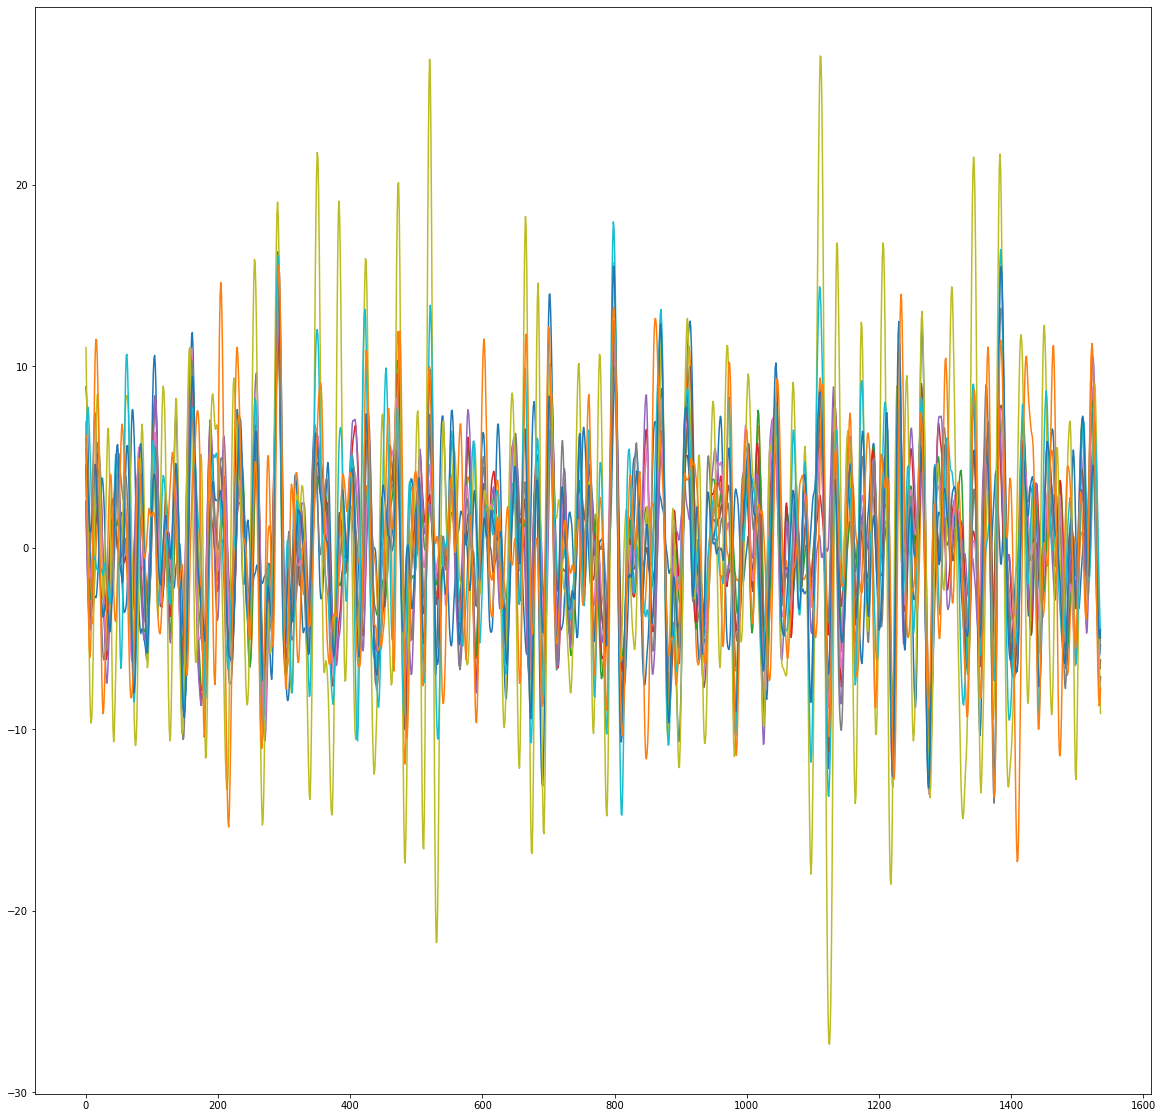

0 0
Epoch 1/500

Epoch 00001: val_loss improved from inf to 0.69563, saving model to /tmp/checkpoint.h5
4/4 - 0s - loss: 0.7385 - accuracy: 0.4200 - val_loss: 0.6956 - val_accuracy: 0.5000
Epoch 2/500

Epoch 00002: val_loss did not improve from 0.69563
4/4 - 0s - loss: 0.6433 - accuracy: 0.6000 - val_loss: 0.6965 - val_accuracy: 0.4500
Epoch 3/500

Epoch 00003: val_loss did not improve from 0.69563
4/4 - 0s - loss: 0.6171 - accuracy: 0.7200 - val_loss: 0.6983 - val_accuracy: 0.5000
Epoch 4/500

Epoch 00004: val_loss did not improve from 0.69563
4/4 - 0s - loss: 0.6004 - accuracy: 0.7800 - val_loss: 0.7034 - val_accuracy: 0.5000
Epoch 5/500

Epoch 00005: val_loss did not improve from 0.69563
4/4 - 0s - loss: 0.5825 - accuracy: 0.8400 - val_loss: 0.7104 - val_accuracy: 0.5000
Epoch 6/500

Epoch 00006: val_loss did not improve from 0.69563
4/4 - 0s - loss: 0.5596 - accuracy: 0.8200 - val_loss: 0.7188 - val_accuracy: 0.5000
Epoch 7/500

Epoch 00007: val_loss did not improve from 0.69563
4/

In [18]:
K.clear_session()

X_tr = np.empty([80, 12, 4096])
result=[]

h_cut = [30] # [only alpha, alpha + low beta, alpha + beta] 18, 24, 30
drop_out = [0.25] # 0.25, 0.5
k_len = [256] # 32, 64, 128, 256
n_epochs = 500
model_name = 'EEGNet'
kernels, chans, samples = 1, 12, 1536

outfname = 'accuray_epochs' + str(n_epochs) + '_filter_' + str(h_cut) + '_drop_' + str(drop_out) + '_model_' + str(model_name) + '_patient_data.pickle'
outfname_history = 'accuray_epochs' + str(n_epochs) + '_filter_' + str(h_cut) + '_drop_' + str(drop_out) + '_model_' + str(model_name) + '_history_data.pickle'


nsub = 1
nfilt = len(h_cut)
ndrop = len(drop_out)
nkl = len(k_len)
acc_sub = np.zeros([nsub, nfilt,ndrop,nkl])
hyper_parameter_matrix = np.zeros([nsub, nfilt, ndrop, nkl, 5])
history = {}

for sub_idx, x in enumerate(range(1,nsub+1)):
    for h_indx, h in enumerate(h_cut):
        fName = 'Dissertation/EEG data/parsed_P0' + str(x) + 'T.mat'  # Load Data
        print(fName)
        mat = spio.loadmat(fName)
        r_X_tr = mat['RawEEGData']
        y_tr = mat['Labels']
        y_tr = y_tr.flatten() 

        print(np.shape(r_X_tr))
        print(np.shape(y_tr))

        for t in range(r_X_tr.shape[0]):
            tril = r_X_tr[t,:,:]
            #tril = tril.transpose()
            tril_filtered = butter_bandpass_filter(tril, lowcut=8, highcut=h, fs=512, order=4)
            # tril_filtered = tril_filtered.transpose()
            X_tr[t,:,:] = tril_filtered 

        # split data of each subject in training and validation
        X_train = X_tr[0:50,:,2048:3584]
        Y_train = y_tr[0:50]
        X_val = X_tr[50:70,:,2048:3584]
        Y_val = y_tr[50:70]
        X_test = X_tr[70:,:,2048:3584]
        Y_test = y_tr[70:]


        print(np.shape(X_train))
        print(np.shape(Y_train))
        print(np.shape(X_val))
        print(np.shape(Y_val))
        print(np.shape(X_test))
        print(np.shape(Y_test))

        # convert labels to one-hot encodings.
        Y_train = np_utils.to_categorical(Y_train-1, num_classes=2)
        Y_val = np_utils.to_categorical(Y_val-1, num_classes=2)
        Y_test = np_utils.to_categorical(Y_test-1, num_classes=2)

        # convert data to NCHW (trials, kernels, channels, samples) format. Data 
        # contains 22 channels and 500 time-points. Set the number of kernels to 1.
        X_train = X_train.reshape(X_train.shape[0], kernels, chans, samples)
        X_val = X_val.reshape(X_val.shape[0], kernels, chans, samples)
        X_test = X_test.reshape(X_test.shape[0], kernels, chans, samples)

        print('X_train shape:', X_train.shape)
        print(X_train.shape[0], 'train samples')
        print(X_val.shape[0], 'val samples')

        print('X_train shape:', X_test.shape)
        print(X_test.shape[0], 'test samples')
        plt.figure(figsize=(20,20))
        for i in range(np.shape(X_train)[2]):
          plt.plot(X_train[0,:,i,:][0])
        plt.show()

        for id_d, d in enumerate(drop_out):
            for id_kl, kl in enumerate(k_len):
              print(id_kl, id_d)
              # configure the EEGNet-8,2,16 model with kernel length of 32 samples (other 
              # model configurations may do better, but this is a good starting point)
              model = EEGNet(nb_classes = 2, Chans = chans, Samples = samples,
                             dropoutRate = d, kernLength = kl, F1 = 8,D = 2, F2 = 16,
                             norm_rate = 0.25, dropoutType = 'Dropout')
              #model.add_metric(tfa.metrics.CohenKappa(num_classes=2), name = 'kappa') #remove later

              # compile the model and set the optimizers
              model.compile(loss='categorical_crossentropy', optimizer='adam', 
                            metrics = ['accuracy'])

              # count number of parameters in the model
              numParams    = model.count_params() 

              # set a valid path for your system to record model checkpoints
              checkpointer = ModelCheckpoint(filepath='/tmp/checkpoint.h5', verbose=1, save_best_only=True)

              # the syntax is {class_1:weight_1, class_2:weight_2,...}. Here just setting
              # the weights all to be 1
              class_weights = {0:1, 1:1}

              history_temp = model.fit(X_train, Y_train, batch_size = 16, epochs = n_epochs, 
                              verbose = 2, validation_data=(X_val, Y_val),
                              callbacks=[checkpointer], class_weight = class_weights)
          
              history[sub_idx,h_indx,id_d] = history_temp.history

              print('\n# Evaluate on test data')


              results = model.evaluate(X_test, Y_test)
              print('test loss, test acc:', results)

              print(results)
              acc_sub[sub_idx,h_indx,id_d, id_kl] = results[1]
              hyper_parameter_matrix[sub_idx,h_indx,id_d, id_kl, :] = [x, h, d, kl, results[1]]

              K.clear_session()
              del checkpointer, model
              
with open(outfname, 'wb') as handle:
    pickle.dump(hyper_parameter_matrix, handle, protocol=pickle.HIGHEST_PROTOCOL)         
with open(outfname_history, 'wb') as handle:
    pickle.dump(history, handle, protocol=pickle.HIGHEST_PROTOCOL)


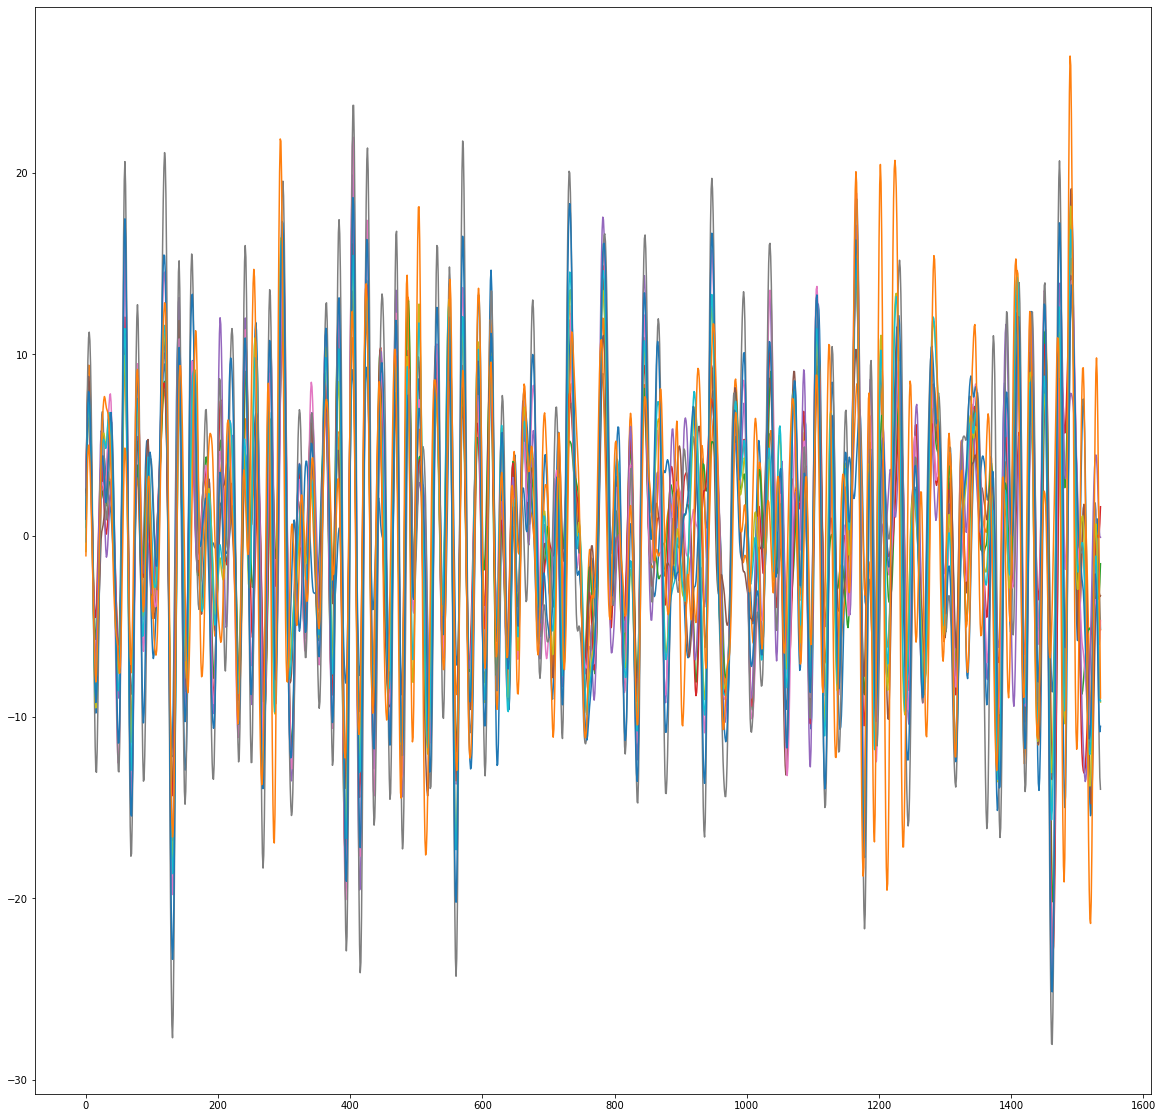

In [15]:
plt.figure(figsize=(20,20))
for i in range(np.shape(X_train)[2]):
  plt.plot(X_train[0,:,i,:][0])
plt.show()

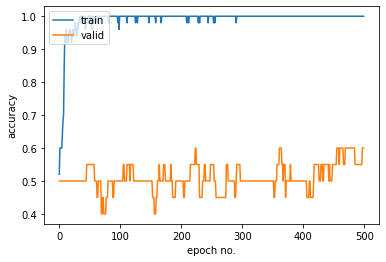

<Figure size 432x288 with 0 Axes>

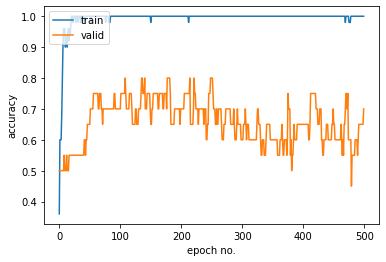

<Figure size 432x288 with 0 Axes>

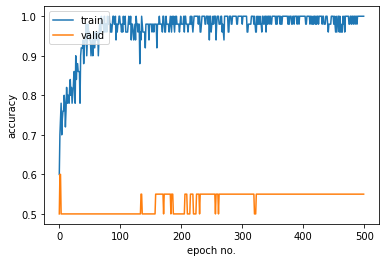

<Figure size 432x288 with 0 Axes>

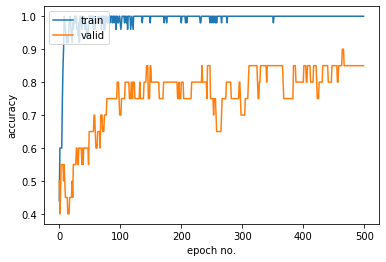

<Figure size 432x288 with 0 Axes>

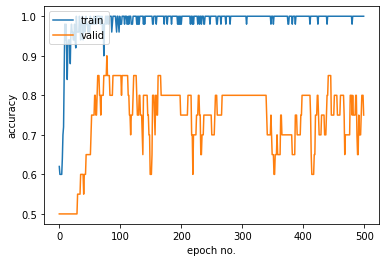

<Figure size 432x288 with 0 Axes>

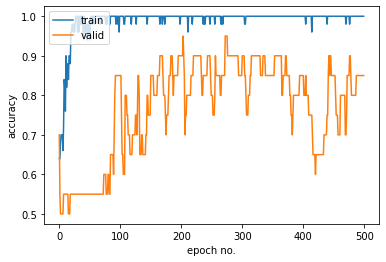

<Figure size 432x288 with 0 Axes>

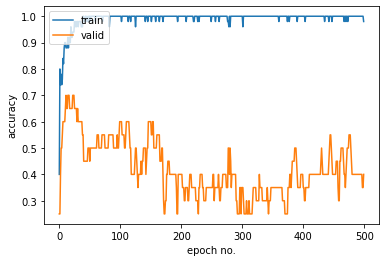

<Figure size 432x288 with 0 Axes>

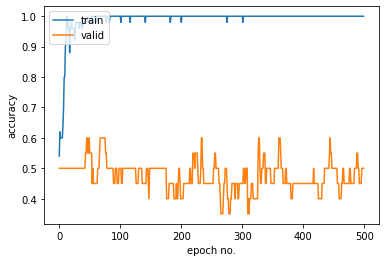

<Figure size 432x288 with 0 Axes>

In [22]:
from google.colab import files

h_cut = [30] # [only alpha, alpha + low beta, alpha + beta]
drop_out = [0.25]
n_epochs = 500
model_name = 'EEGNet'  # ShallowConvNet or DeepConvNet
kernels, chans, samples = 1, 12, 1536
subject = 1
outfname_history = 'accuray_epochs' + str(n_epochs) + '_filter_' + str(h_cut) + '_drop_' + str(drop_out) + '_model_' + str(model_name) + '_history_data.pickle'

with open(outfname_history, 'rb') as handle:
    history = pickle.load(handle)

for key in history.keys():
  plt.figure()
  history_ = history[key]
  plt.plot(history_['accuracy'])
  plt.plot(history_['val_accuracy'])
  plt.ylabel('accuracy')
  plt.xlabel('epoch no.')
  plt.legend(['train', 'valid'], loc='upper left')
  plt.show()
  plt.savefig('accuracy_epochs' + str(n_epochs) + '_filter_' + str(h_cut) + '_drop_' + str(drop_out) + '_model_' + str(model_name) + 'subject '+str(subject)+'.jpeg')
  #files.download('accuracy_epochs' + str(n_epochs) + '_filter_' + str(h_cut) + '_drop_' + str(drop_out) + '_model_' + str(model_name) + 'subject '+str(subject)+'.jpeg')
  subject += 1


In [39]:
  files.download('accuracy_epochs500_filter_[30]_drop_[0.25]_model_EEGNetsubject:1.jpeg')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [33]:
ls

'accuracy_epochs500_filter_[30]_drop_[0.25]_model_EEGNetsubject:1.jpeg'
'accuracy_epochs500_filter_[30]_drop_[0.25]_model_EEGNetsubject:2.jpeg'
'accuracy_epochs500_filter_[30]_drop_[0.25]_model_EEGNetsubject:3.jpeg'
'accuracy_epochs500_filter_[30]_drop_[0.25]_model_EEGNetsubject:4.jpeg'
'accuracy_epochs500_filter_[30]_drop_[0.25]_model_EEGNetsubject:5.jpeg'
'accuracy_epochs500_filter_[30]_drop_[0.25]_model_EEGNetsubject:6.jpeg'
'accuracy_epochs500_filter_[30]_drop_[0.25]_model_EEGNetsubject:7.jpeg'
'accuracy_epochs500_filter_[30]_drop_[0.25]_model_EEGNetsubject:8.jpeg'
'accuracy_epochs500_filter_[30]_drop_[0.25]_model_EEGNetsubject:.jpeg'
'accuracy_epochs500_filter_[30]_drop_[0.25]_model_EEGNetsubject.jpeg'
'accuray_epochs500_filter_[30]_drop_[0.25]_model_DeepConvNet_history_data.pickle'
'accuray_epochs500_filter_[30]_drop_[0.25]_model_DeepConvNet_patient_data.pickle'
'accuray_epochs500_filter_[30]_drop_[0.25]_model_EEGNet_history_data.pickle'
'accuray_epochs500_filter_[30]_drop_[0.25]

In [8]:
K.clear_session()

X_tr = np.empty([80, 12, 4096])
result=[]

h_cut = [30] # [only alpha, alpha + low beta, alpha + beta]
drop_out = [0.25]
n_epochs = 500
model_name = 'DeepConvNet'  # ShallowConvNet or DeepConvNet
kernels, chans, samples = 1, 12, 1536

outfname = 'accuray_epochs' + str(n_epochs) + '_filter_' + str(h_cut) + '_drop_' + str(drop_out) + '_model_' + str(model_name) + '_patient_data.pickle'
outfname_history = 'accuray_epochs' + str(n_epochs) + '_filter_' + str(h_cut) + '_drop_' + str(drop_out) + '_model_' + str(model_name) + '_history_data.pickle'

nsub = 8
nfilt = len(h_cut)
ndrop = len(drop_out)
acc_sub = np.zeros([nsub, nfilt,ndrop])
hyper_parameter_matrix = np.zeros([nsub, nfilt, ndrop, 4])
history={}

for sub_idx, x in enumerate(range(1,nsub+1)):
    for h_indx, h in enumerate(h_cut):
        fName = 'Dissertation/EEG data/parsed_P0' + str(x) + 'T.mat'  # Load Data
        print(fName)
        mat = spio.loadmat(fName)
        r_X_tr = mat['RawEEGData']
        y_tr = mat['Labels']
        y_tr = y_tr.flatten() 

        print(np.shape(r_X_tr))
        print(np.shape(y_tr))

        for t in range(r_X_tr.shape[0]):
            tril = r_X_tr[t,:,:]
            #tril = tril.transpose()
            tril_filtered = butter_bandpass_filter(tril, lowcut=8, highcut=h, fs=512, order=4)
            # tril_filtered = tril_filtered.transpose()
            X_tr[t,:,:] = tril_filtered 

        # split data of each subject in training and validation
        X_train = X_tr[0:50,:,2048:3584]
        Y_train = y_tr[0:50]
        X_val = X_tr[50:70,:,2048:3584]
        Y_val = y_tr[50:70]
        X_test = X_tr[70:,:,2048:3584]
        Y_test = y_tr[70:]

        print(np.shape(X_train))
        print(np.shape(Y_train))
        print(np.shape(X_val))
        print(np.shape(Y_val))
        print(np.shape(X_test))
        print(np.shape(Y_test))

        # convert labels to one-hot encodings.
        Y_train = np_utils.to_categorical(Y_train-1, num_classes=2)
        Y_val = np_utils.to_categorical(Y_val-1, num_classes=2)
        Y_test = np_utils.to_categorical(Y_test-1, num_classes=2)

        # convert data to NCHW (trials, kernels, channels, samples) format. Data 
        # contains 22 channels and 500 time-points. Set the number of kernels to 1.
        X_train = X_train.reshape(X_train.shape[0], kernels, chans, samples)
        X_val = X_val.reshape(X_val.shape[0], kernels, chans, samples)
        X_test = X_test.reshape(X_test.shape[0], kernels, chans, samples)

        print('X_train shape:', X_train.shape)
        print(X_train.shape[0], 'train samples')
        print(X_val.shape[0], 'val samples')

        print('X_train shape:', X_test.shape)
        print(X_test.shape[0], 'test samples')

        for id_d, d in enumerate(drop_out):
          print(id_d)
          
          if model_name == 'DeepConvNet':
            model = DeepConvNet(nb_classes=2, Chans = chans, Samples = samples, dropoutRate = d)
          elif model_name == 'ShallowConvNet':
            model = ShallowConvNet(nb_classes = 2, Chans = chans, Samples = samples, dropoutRate = d)
          else:
            raise ValueError('Model name wrong!')
          

          # compile the model and set the optimizers
          model.compile(loss='categorical_crossentropy', optimizer='adam', 
                        metrics = ['accuracy'])

          # count number of parameters in the model
          numParams    = model.count_params() 

          # set a valid path for your system to record model checkpoints
          checkpointer = ModelCheckpoint(filepath='/tmp/checkpoint.h5', verbose=1, save_best_only=True)

          # the syntax is {class_1:weight_1, class_2:weight_2,...}. Here just setting
          # the weights all to be 1
          class_weights = {0:1, 1:1}

          history_temp = model.fit(X_train, Y_train, batch_size = 16, epochs = n_epochs, 
                              verbose = 2, validation_data=(X_val, Y_val),
                              callbacks=[checkpointer], class_weight = class_weights)
          
          history[sub_idx,h_indx,id_d] = history_temp.history

          print('\n# Evaluate on test data')


          results = model.evaluate(X_test, Y_test)
          print('test loss, test acc:', results)

          print(results)
          acc_sub[sub_idx,h_indx,id_d] = results[1]
          hyper_parameter_matrix[sub_idx,h_indx,id_d, :] = [x, h, d, results[1]]

          K.clear_session()
with open(outfname, 'wb') as handle:
    pickle.dump(hyper_parameter_matrix, handle, protocol=pickle.HIGHEST_PROTOCOL)         
with open(outfname_history, 'wb') as handle:
    pickle.dump(history, handle, protocol=pickle.HIGHEST_PROTOCOL)      


Streaming output truncated to the last 5000 lines.

Epoch 00262: val_loss did not improve from 0.74447
4/4 - 0s - loss: 4.9649e-04 - accuracy: 1.0000 - val_loss: 2.2753 - val_accuracy: 0.5500
Epoch 263/500

Epoch 00263: val_loss did not improve from 0.74447
4/4 - 0s - loss: 4.7475e-05 - accuracy: 1.0000 - val_loss: 1.7846 - val_accuracy: 0.5500
Epoch 264/500

Epoch 00264: val_loss did not improve from 0.74447
4/4 - 0s - loss: 1.1015e-04 - accuracy: 1.0000 - val_loss: 1.3242 - val_accuracy: 0.5000
Epoch 265/500

Epoch 00265: val_loss did not improve from 0.74447
4/4 - 0s - loss: 6.7316e-05 - accuracy: 1.0000 - val_loss: 1.3305 - val_accuracy: 0.6000
Epoch 266/500

Epoch 00266: val_loss did not improve from 0.74447
4/4 - 0s - loss: 5.7654e-05 - accuracy: 1.0000 - val_loss: 1.7743 - val_accuracy: 0.6500
Epoch 267/500

Epoch 00267: val_loss did not improve from 0.74447
4/4 - 0s - loss: 7.6590e-05 - accuracy: 1.0000 - val_loss: 1.9985 - val_accuracy: 0.6000
Epoch 268/500

Epoch 00268: val_l

In [9]:
K.clear_session()

X_tr = np.empty([80, 12, 4096])
result=[]

h_cut = [30] # [only alpha, alpha + low beta, alpha + beta]
drop_out = [0.25]
n_epochs = 500
model_name = 'DeepConvNet'  # ShallowConvNet or DeepConvNet
kernels, chans, samples = 1, 12, 1536

outfname = 'accuray_epochs' + str(n_epochs) + '_filter_' + str(h_cut) + '_drop_' + str(drop_out) + '_model_' + str(model_name) + '_patient_data.pickle'
outfname_history = 'accuray_epochs' + str(n_epochs) + '_filter_' + str(h_cut) + '_drop_' + str(drop_out) + '_model_' + str(model_name) + '_history_data.pickle'

nsub = 8
nfilt = len(h_cut)
ndrop = len(drop_out)
acc_sub = np.zeros([nsub, nfilt,ndrop])
hyper_parameter_matrix = np.zeros([nsub, nfilt, ndrop, 4])
history={}

for sub_idx, x in enumerate(range(1,nsub+1)):
    for h_indx, h in enumerate(h_cut):
        fName = 'Dissertation/EEG data/parsed_P0' + str(x) + 'T.mat'  # Load Data
        print(fName)
        mat = spio.loadmat(fName)
        r_X_tr = mat['RawEEGData']
        y_tr = mat['Labels']
        y_tr = y_tr.flatten() 

        print(np.shape(r_X_tr))
        print(np.shape(y_tr))

        for t in range(r_X_tr.shape[0]):
            tril = r_X_tr[t,:,:]
            #tril = tril.transpose()
            tril_filtered = butter_bandpass_filter(tril, lowcut=8, highcut=h, fs=512, order=4)
            # tril_filtered = tril_filtered.transpose()
            X_tr[t,:,:] = tril_filtered 

        # split data of each subject in training and validation
        X_train = X_tr[0:50,:,2048:3584]
        Y_train = y_tr[0:50]
        X_val = X_tr[50:70,:,2048:3584]
        Y_val = y_tr[50:70]
        X_test = X_tr[70:,:,2048:3584]
        Y_test = y_tr[70:]

        print(np.shape(X_train))
        print(np.shape(Y_train))
        print(np.shape(X_val))
        print(np.shape(Y_val))
        print(np.shape(X_test))
        print(np.shape(Y_test))

        # convert labels to one-hot encodings.
        Y_train = np_utils.to_categorical(Y_train-1, num_classes=2)
        Y_val = np_utils.to_categorical(Y_val-1, num_classes=2)
        Y_test = np_utils.to_categorical(Y_test-1, num_classes=2)

        # convert data to NCHW (trials, kernels, channels, samples) format. Data 
        # contains 22 channels and 500 time-points. Set the number of kernels to 1.
        X_train = X_train.reshape(X_train.shape[0], kernels, chans, samples)
        X_val = X_val.reshape(X_val.shape[0], kernels, chans, samples)
        X_test = X_test.reshape(X_test.shape[0], kernels, chans, samples)

        print('X_train shape:', X_train.shape)
        print(X_train.shape[0], 'train samples')
        print(X_val.shape[0], 'val samples')

        print('X_train shape:', X_test.shape)
        print(X_test.shape[0], 'test samples')

        for id_d, d in enumerate(drop_out):
          print(id_d)
          
          if model_name == 'DeepConvNet':
            model = DeepConvNet(nb_classes=2, Chans = chans, Samples = samples, dropoutRate = d)
          elif model_name == 'ShallowConvNet':
            model = ShallowConvNet(nb_classes = 2, Chans = chans, Samples = samples, dropoutRate = d)
          else:
            raise ValueError('Model name wrong!')
          

          # compile the model and set the optimizers
          model.compile(loss='categorical_crossentropy', optimizer='adam', 
                        metrics = ['accuracy'])

          # count number of parameters in the model
          numParams    = model.count_params() 

          # set a valid path for your system to record model checkpoints
          checkpointer = ModelCheckpoint(filepath='/tmp/checkpoint.h5', verbose=1, save_best_only=True)

          # the syntax is {class_1:weight_1, class_2:weight_2,...}. Here just setting
          # the weights all to be 1
          class_weights = {0:1, 1:1}

          history_temp = model.fit(X_train, Y_train, batch_size = 16, epochs = n_epochs, 
                              verbose = 2, validation_data=(X_val, Y_val),
                              callbacks=[checkpointer], class_weight = class_weights)
          
          history[sub_idx,h_indx,id_d] = history_temp.history

          print('\n# Evaluate on test data')


          results = model.evaluate(X_test, Y_test)
          print('test loss, test acc:', results)

          print(results)
          acc_sub[sub_idx,h_indx,id_d] = results[1]
          hyper_parameter_matrix[sub_idx,h_indx,id_d, :] = [x, h, d, results[1]]

          K.clear_session()
with open(outfname, 'wb') as handle:
    pickle.dump(hyper_parameter_matrix, handle, protocol=pickle.HIGHEST_PROTOCOL)         
with open(outfname_history, 'wb') as handle:
    pickle.dump(history, handle, protocol=pickle.HIGHEST_PROTOCOL)      


Streaming output truncated to the last 5000 lines.

Epoch 00262: val_loss did not improve from 0.64987
4/4 - 0s - loss: 5.6158e-05 - accuracy: 1.0000 - val_loss: 1.7329 - val_accuracy: 0.5000
Epoch 263/500

Epoch 00263: val_loss did not improve from 0.64987
4/4 - 0s - loss: 1.0142e-04 - accuracy: 1.0000 - val_loss: 1.7163 - val_accuracy: 0.5500
Epoch 264/500

Epoch 00264: val_loss did not improve from 0.64987
4/4 - 0s - loss: 1.1318e-04 - accuracy: 1.0000 - val_loss: 1.7728 - val_accuracy: 0.5500
Epoch 265/500

Epoch 00265: val_loss did not improve from 0.64987
4/4 - 0s - loss: 6.0372e-05 - accuracy: 1.0000 - val_loss: 1.6286 - val_accuracy: 0.5500
Epoch 266/500

Epoch 00266: val_loss did not improve from 0.64987
4/4 - 0s - loss: 5.7268e-05 - accuracy: 1.0000 - val_loss: 1.7488 - val_accuracy: 0.6000
Epoch 267/500

Epoch 00267: val_loss did not improve from 0.64987
4/4 - 0s - loss: 1.1212e-04 - accuracy: 1.0000 - val_loss: 1.7076 - val_accuracy: 0.5500
Epoch 268/500

Epoch 00268: val_l

In [7]:

h_cut = [30] # [only alpha, alpha + low beta, alpha + beta]
drop_out = [0.25]
n_epochs = 500
model_name = 'DeepConvNet'  # ShallowConvNet or DeepConvNet
kernels, chans, samples = 1, 12, 1536

outfname = 'accuray_epochs' + str(n_epochs) + '_filter_' + str(h_cut) + '_drop_' + str(drop_out) + '_model_' + str(model_name) + '_patient_data.npy'

hyper_parameter_matrix = np.load(outfname)

ind = np.unravel_index(np.argmax(acc_sub, axis=None), acc_sub.shape)
acc_sub
hyper_parameter_matrix
hyper_parameter_matrix[ind]
reduced_acc_sub = np.mean(acc_sub, axis=0, keepdims=True)
ind_reduced = np.unravel_index(np.argmax(reduced_acc_sub, axis=None), reduced_acc_sub.shape)
print('Index is: {}'.format(ind_reduced[-1]))
print('Hyperparameters are: {}'.format(hyper_parameter_matrix[ind_reduced]))
print(hyper_parameter_matrix[ind_reduced])
print(acc_sub)
#files.download('accuray_epochs500_filter_[12, 18, 30]_drop_[0.25, 0.5]_model_ShallowConvNet_patient_data.npy') 


FileNotFoundError: ignored